In [1]:
import numpy as np
import torch
import random
import pickle
from tqdm import tqdm

device = "cpu"#torch.device('cuda' if torch.cuda.is_available() else 'cpu')
display(device)

import operator
from transformers import DecisionTransformerConfig, DecisionTransformerModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import wandb

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import time
import itertools
import matplotlib.pyplot as plt

import sys
sys.path.append('../key_door_env/')
from key_door import key_door_env
from key_door import visualisation_env
from torch.optim.lr_scheduler import ReduceLROnPlateau

/home/kurise/anaconda3/envs/mujoco_py/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cpu'

In [2]:
class PPO_KTD_Dataset(Dataset):
    def __init__(self, path, gamma):
        with open(path, 'rb') as f:
            self.data = pickle.load(f)
            
        self.width = self.data[0]['state'].shape[1]
        self.gamma = gamma

        self.std = torch.std(torch.cat([torch.from_numpy(self.data[traj]['state']).float() for traj in self.data]), dim=0) + 1e-6
        self.mean = torch.mean(torch.cat([torch.from_numpy(self.data[traj]['state']).float() for traj in self.data]), dim=0)
        self.std[2] = 1
        self.mean[2] = 0
        print(self.std)
        print(self.mean)
        
    def discount_cumsum(self, x):
        discount_cumsum = np.zeros_like(x)
        discount_cumsum[-1] = x[-1]
        for t in reversed(range(x.shape[0]-1)):
            discount_cumsum[t] = x[t] + self.gamma * discount_cumsum[t+1]
        return discount_cumsum

    def __getitem__(self, index):
        traj = self.data[index]
        length = traj['state'].shape[0]
        s = (torch.from_numpy(traj['state']).float() - self.mean) / self.std
        #s[:, 3] = 0
        # s = torch.from_numpy(traj['state']).float() 
        s = s.reshape(1, length, self.width)
        a = torch.from_numpy(traj['action'])
        b = torch.zeros((a.shape[0], 4))
        
        for i in range(a.shape[0]):
            if a[i] == 0:
                b[i] = torch.Tensor([1, 0, 0, 0])
            elif a[i] == 1:
                b[i] = torch.Tensor([0, 1, 0, 0])
            elif a[i] == 2:
                b[i] = torch.Tensor([0, 0, 1, 0])
            elif a[i] == 3:
                b[i] = torch.Tensor([0, 0, 0, 1])
        
        b = b.reshape(1, length, 4)
                
        # a = -0.5 * a + 0.5
        #a = a.reshape(1, length, self.width)
        rtg = torch.from_numpy(self.discount_cumsum(traj['reward']).reshape(1, length, 1))
        d = torch.from_numpy(traj['done'].reshape(1, length, 1))
        timesteps = torch.from_numpy(np.arange(0, length).reshape(1, -1, 1))

        # Pad with zeros if length is less than 5000
        if length < 100:
            pad_length = 100 - length
            s = F.pad(s, (0, 0, 0, pad_length, 0, 0), value=0)
            # a = F.pad(a, (0, 0, 0, pad_length, 0, 0), value=0)
            b = F.pad(b, (0, 0, 0, pad_length, 0, 0), value=0)
            rtg = F.pad(rtg, (0, 0, 0, pad_length, 0, 0), value=0)
            d = F.pad(d, (0, 0, 0, pad_length, 0, 0), value=0)
            timesteps = F.pad(timesteps, (0, 0, 0, pad_length, 0, 0), value=0)

        return s, b, rtg, d, timesteps

    def __len__(self):
        return len(self.data)

In [3]:
path = '../KTDData/dataKTD_mini_paper_successful_1k.pickle'
dataset = PPO_KTD_Dataset(path, 0.99)
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
_, test_dataset = train_test_split(val_dataset, test_size=0.25, random_state=42)
print(len(train_dataset), len(val_dataset), len(test_dataset), sep='\t')

tensor([6.4097e+00, 1.4045e+00, 1.0000e+00, 1.0000e-06])
tensor([9.5877, 2.7823, 0.0000, 0.0000])
800	200	50


100%|██████████| 50/50 [00:00<00:00, 1002.21it/s]


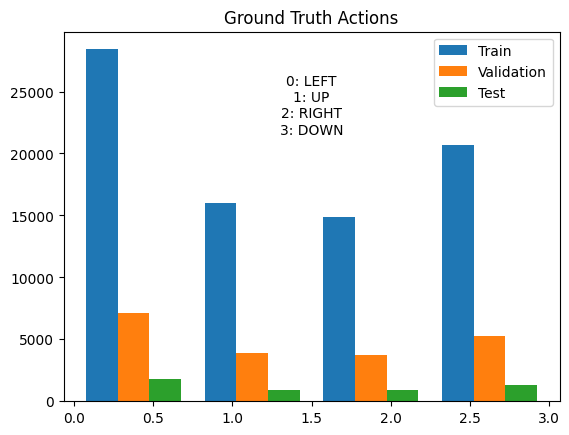

In [4]:
mem_train = []
for _, a, _, _, _ in tqdm(train_dataset):
    for i in range(a.shape[1]):
        mem_train.append(torch.argmax(a[:, i], dim=1).item())
        
mem_val = []
for _, a, _, _, _ in tqdm(val_dataset):
    for i in range(a.shape[1]):
        mem_val.append(torch.argmax(a[:, i], dim=1).item())
        
mem_test = []
for _, a, _, _, _ in tqdm(test_dataset):
    for i in range(a.shape[1]):
        mem_test.append(torch.argmax(a[:, i], dim=1).item())
        
plt.hist([mem_train, mem_val, mem_test], label=['Train', 'Validation', 'Test'], bins=4)
plt.legend()
plt.title("Ground Truth Actions")

# Add the legend as a caption
plt.text(0.5, 0.8, '0: LEFT\n1: UP\n2: RIGHT\n3: DOWN', ha='center', va='center', transform=plt.gca().transAxes)

plt.show()

In [5]:
lr = 1e-4
num_epochs = 500
patience = 20
model_path = f'../models/PPO_KTD_to_DT_models/PPO_KTD_to_DT_1k_lr_{lr}_ep_{num_epochs}_pat_{patience}_mse_loss_2ch.pth'

config = DecisionTransformerConfig(state_dim=4, act_dim=4, n_positions=100*3, max_ep_len=100)
model = DecisionTransformerModel(config)#.to(device)
model.load_state_dict(torch.load(model_path))
model.to("cpu")
_ = model.eval()
# test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=True)

  0%|          | 2/800 [00:00<00:42, 18.93it/s]

100%|██████████| 50/50 [00:02<00:00, 18.42it/s]


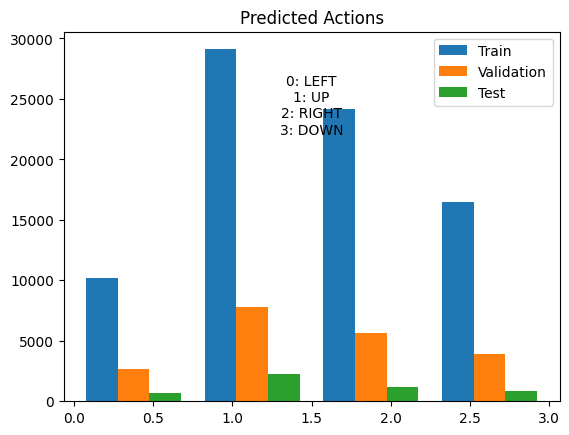

In [6]:
mem_train = []
for s, a, rtg, d, timesteps in tqdm(train_dataset):
    s = s.to(device=device, dtype=torch.float32).squeeze(1)
    a = a.to(device=device, dtype=torch.float32).squeeze(1)
    rtg = rtg.to(device=device, dtype=torch.float32).squeeze(1)
    timesteps = timesteps.to(device=device, dtype=torch.long).squeeze()
    
    _, action_preds, _ = model(
        states=s,
        actions=a,
        returns_to_go=rtg,
        timesteps=timesteps,
        return_dict=False,
    )

    for i in range(action_preds.shape[1]):
        mem_train.append(torch.argmax(action_preds[:, i], dim=1).item())
        

mem_val = []
for s, a, rtg, d, timesteps in tqdm(val_dataset):
    s = s.to(device=device, dtype=torch.float32).squeeze(1)
    a = a.to(device=device, dtype=torch.float32).squeeze(1)
    rtg = rtg.to(device=device, dtype=torch.float32).squeeze(1)
    timesteps = timesteps.to(device=device, dtype=torch.long).squeeze()
    
    _, action_preds, _ = model(
        states=s,
        actions=a,
        returns_to_go=rtg,
        timesteps=timesteps,
        return_dict=False,
    )

    for i in range(action_preds.shape[1]):
        mem_val.append(torch.argmax(action_preds[:, i], dim=1).item())
        
mem_test = []
for s, a, rtg, d, timesteps in tqdm(test_dataset):
    s = s.to(device=device, dtype=torch.float32).squeeze(1)
    a = a.to(device=device, dtype=torch.float32).squeeze(1)
    rtg = rtg.to(device=device, dtype=torch.float32).squeeze(1)
    timesteps = timesteps.to(device=device, dtype=torch.long).squeeze()
    
    _, action_preds, _ = model(
        states=s,
        actions=a,
        returns_to_go=rtg,
        timesteps=timesteps,
        return_dict=False,
    )

    for i in range(action_preds.shape[1]):
        mem_test.append(torch.argmax(action_preds[:, i], dim=1).item())
        
plt.hist([mem_train, mem_val, mem_test], label=['Train', 'Validation', 'Test'], bins=4)
plt.legend()
plt.title("Predicted Actions")

# Add the legend as a caption
plt.text(0.5, 0.8, '0: LEFT\n1: UP\n2: RIGHT\n3: DOWN', ha='center', va='center', transform=plt.gca().transAxes)

plt.show()        

In [34]:
def pred_act(verbose=True, create_video=True):

    map_ascii_path = '../key_door_env/tests/key_door_test_map_files/key_door_sample_map_mini_paper_2.txt'
    map_yaml_path = '../key_door_env/tests/key_door_test_map_files/key_door_sample_map_mini_paper_2.yaml'
    episode_timeout = 100

    # Create environment
    env = key_door_env.KeyDoorEnv(
        map_ascii_path=map_ascii_path,
        map_yaml_path=map_yaml_path,
        representation="agent_position",
        episode_timeout=episode_timeout
    )
    
    state = env.reset_environment(map_yaml_path=map_yaml_path)
    # env.agent_position = (1, 9)
    state = torch.Tensor(state).reshape(1, -1, 4)
    state = (state - dataset.mean) / dataset.std
    vector = np.zeros((1, 4))
    random_index = np.random.randint(4)
    vector[0, random_index] = 1
    
    act = torch.Tensor([[vector.tolist()[0]]])
    if verbose:
        print("Initial step:", act)
    done = False
    timer = 0
    s, a, rew, d = [], [], [], []
    
    
    while not done:
        if timer == 0:
            rtg = torch.Tensor([[[1.]]]).to(dtype=torch.float32)
            ts = torch.Tensor([[timer]]).to(dtype=torch.long)
        else:
            rtg = torch.cat((rtg, torch.Tensor([[[1.]]]).to(dtype=torch.float32)), dim=1)
            ts = torch.cat((ts, torch.Tensor([[timer]]).to(dtype=torch.long)), dim=1)
        
        with torch.no_grad():
            _, act_new, _ = model(
                            states=state,
                            actions=act,
                            returns_to_go=rtg,
                            timesteps=ts,
                            return_dict=False,
                            )
        act_ans = torch.argmax(act_new[:, -1], dim=-1).item()
        
        
        # if 1 >= act_new[:,-1].item() >= 0.75:
        #     act_ans = 3
        # elif 0.75 > act_new[:,-1].item() >= 0.5:
        #     act_ans = 2
        # elif -0.5 >= act_new[:,-1].item() > -0.75:
        #     act_ans = 1
        # elif -0.75 >= act_new[:,-1].item() >= -1.0:
        #     act_ans = 0
        
        reward, next_state = env.step(act_ans)
        
        #print('\n', np.round(act_new[:,-1], 2), act_ans, state[:, -1], reward)
        # print(f"\rCurrent timer value: {timer} / {episode_timeout}, {act_new[:,-1].item():.2f}, act: {act_ans}, state: {next_state}", end="")
        if verbose:
            print(f"\rCurrent timer value: {timer} / {episode_timeout}, {act_new[:,-1][0]}, act: {act_ans}, state: {next_state}", end="")
        
        done = not env._remain_active(reward)
        if timer == episode_timeout // 3:
            env.agent_position = (11,2) #(17,2), (6,2)
        elif timer == 2 * episode_timeout // 3:
            env.agent_position = (20,5)
        
        s.append(state)
        a.append(act_ans)
        rew.append(reward)
        d.append(done)
        state = torch.cat((state, (torch.Tensor([[next_state]]) - dataset.mean) / dataset.std), dim=1)
        act = torch.cat((act, act_new[:, -1].unsqueeze(1)), dim=1)
        
        timer += 1
        
        if done:
            #s = np.concatenate([s[i] for i in range(len(s))], axis=1).reshape(-1, 3)
            s = state.detach().cpu().numpy().reshape(-1,4)[0:-1]
            a = np.array(a)
            rew = np.array(rew)
            d = np.array(d)
        
        last_rew = reward
        
    if verbose:
        print("\nThe process ended with a reward of {} at time {}".format(reward, timer))
    if create_video:
        print("Creating video...")
        history = env._train_episode_history
        env = visualisation_env.VisualisationEnv(env)
        env.visualise_episode_history(f'../Key_to_Door/results/DT/PPO_KTD_to_DT_1k.mp4', history)
        print("Video created.")
    
    return s, a, rtg, d, last_rew

In [35]:
s, a, rtg, d, last_rew = pred_act(verbose=True, create_video=True)

Initial step: tensor([[[0., 0., 1., 0.]]])
Current timer value: 73 / 100, tensor([0.6651, 0.0926, 0.0912, 0.1511]), act: 0, state: (17, 1, 1, 1)
The process ended with a reward of 1.0 at time 74
Creating video...
Video created.


In [36]:
num_samples = 100
goods = 0
bads = 0
for i in tqdm(range(num_samples)):
    s, a, rtg, d, last_rew = pred_act(verbose=False, create_video=False)
    if last_rew == 1:
        goods += 1
    else:
        bads += 1
        
print("Succes rate:", goods / (goods + bads))

100%|██████████| 100/100 [00:39<00:00,  2.51it/s]

Succes rate: 1.0
